In [11]:
import numpy as np
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
from Preprocessing.preprocess import modified_z_score, fixer, baseline_als
import sklearn.linear_model as linear_model
from sklearn.linear_model import LinearRegression
import pandas as pd

c:\Users\ariaw\AppData\Local\miniconda3\envs\proyek-lemak\Lib\site-packages\ternary\plotting.py:148: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(xs, ys, vmin=vmin, vmax=vmax, **kwargs)


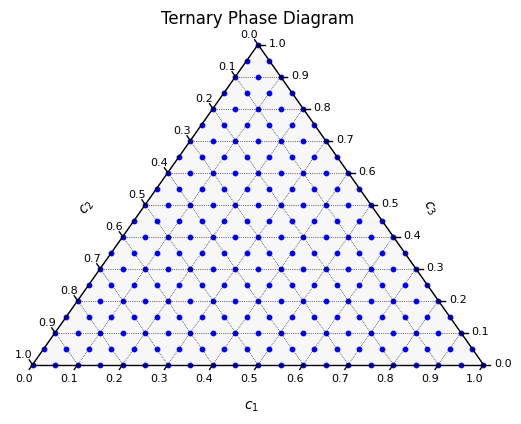

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import ternary

def generate_ternary_combinations(step=0.01):
    compositions = np.arange(0, 1 + step, step)
    ternary_combinations = []

    for x in compositions:
        for y in compositions:
            z = 1 - x - y
            if -1e-7 <= z <= 1:
                ternary_combinations.append([x, y, z])
    
    return ternary_combinations

def plot_ternary_diagram(ternary_combinations):
    figure, tax = ternary.figure(scale=1.0)
    tax.boundary(linewidth=1.0)
    tax.gridlines(multiple=0.1, color="black")

    points = np.array(ternary_combinations)
    tax.scatter(points, marker='o', color='blue', s=10)

    tax.set_title("Ternary Phase Diagram")
    tax.ticks(axis='lbr', linewidth=1, multiple=0.1, tick_formats="%.1f", offset=0.015, fontsize=8)
    tax.get_axes().axis('off')
    tax.bottom_axis_label(r"$c_1$", offset=0.05)
    tax.left_axis_label(r"$c_2$", offset=0.14)
    tax.right_axis_label(r"$c_3$", offset=0.14)
    tax.clear_matplotlib_ticks()
    tax.show()


step_size = 0.05
ternary_combinations = generate_ternary_combinations(step_size)
plot_ternary_diagram(ternary_combinations)

In [13]:
c_a, c_b, c_c = [], [], []
for x, y, z in ternary_combinations:
    c_a.append(x)
    c_b.append(y)
    c_c.append(z)

c_a = np.array(c_a)
c_b = np.array(c_b)
c_c = np.array(c_c)

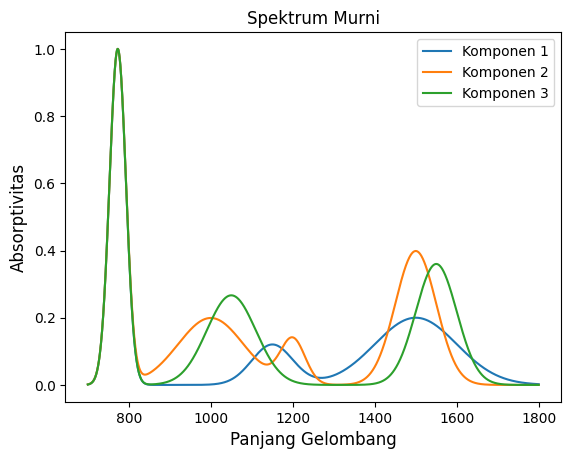

In [14]:

def Gauss(x, mu, sigma, A=1):
    return A * np.exp(-(x - mu) ** 2 / (2 * sigma ** 2)) / (sigma * np.sqrt(2 * np.pi))

x_range = np.linspace(700, 1800, 2000)
# First component
mu_a1 = 773
sigma_a1 = 20
intensity_a1 = 1

mu_a2 = 1150
sigma_a2 = 50
intensity_a2 = 0.3

mu_a3 = 1500
sigma_a3 = 100
intensity_a3 = 1

gauss_a = Gauss(x_range, mu_a1, sigma_a1, intensity_a1) + Gauss(x_range, mu_a2, sigma_a2, intensity_a2) + Gauss(x_range, mu_a3, sigma_a3, intensity_a3)

# Second component
mu_b1 = 773
sigma_b1 = 20
intensity_b1 = 1

mu_b2 = 1000
sigma_b2 = 80
intensity_b2 = 0.8

mu_b3 = 1200
sigma_b3 = 30
intensity_b3 = 0.2

mu_b4 = 1500
sigma_b4 = 50
intensity_b4 = 1

gauss_b = Gauss(x_range, mu_b1, sigma_b1, intensity_b1) + Gauss(x_range, mu_b2, sigma_b2, intensity_b2) + Gauss(x_range, mu_b3, sigma_b3, intensity_b3) + Gauss(x_range, mu_b4, sigma_b4, intensity_b4)

# Third component
mu_c1 = 773
sigma_c1 = 20
intensity_c1 = 1

mu_c2 = 1050
sigma_c2 = 60
intensity_c2 = 0.8

mu_c3 = 1550
sigma_c3 = 50
intensity_c3 = 0.9

gauss_c = Gauss(x_range, mu_c1, sigma_c1, intensity_c1) + Gauss(x_range, mu_c2, sigma_c2, intensity_c2) + Gauss(x_range, mu_c3, sigma_c3, intensity_c3)

# Normalization
component_a = gauss_a / np.max(gauss_a)
component_b = gauss_b / np.max(gauss_b)
component_c = gauss_c / np.max(gauss_c)


plt.plot(x_range, component_a, label = 'Komponen 1')
plt.plot(x_range, component_b, label = 'Komponen 2')
plt.plot(x_range, component_c, label = 'Komponen 3')
plt.title('Spektrum Murni', fontsize = 12)
plt.xlabel('Panjang Gelombang', fontsize = 12)
plt.ylabel('Absorptivitas', fontsize = 12)
plt.legend()
plt.show()

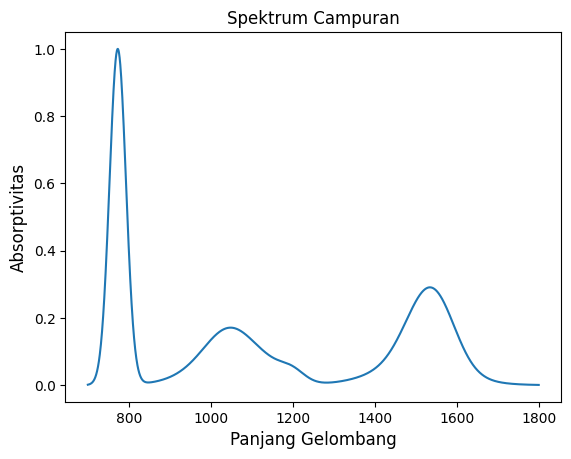

In [15]:
# Mixture
mixture = np.array([c_a, c_b, c_c]).T @ np.array([component_a, component_b, component_c])
# How does it look?
plt.plot(x_range, mixture.T[:,115])
plt.title('Spektrum Campuran', fontsize = 12)
plt.xlabel('Panjang Gelombang', fontsize = 12)
plt.ylabel('Absorptivitas', fontsize = 12)
plt.show()


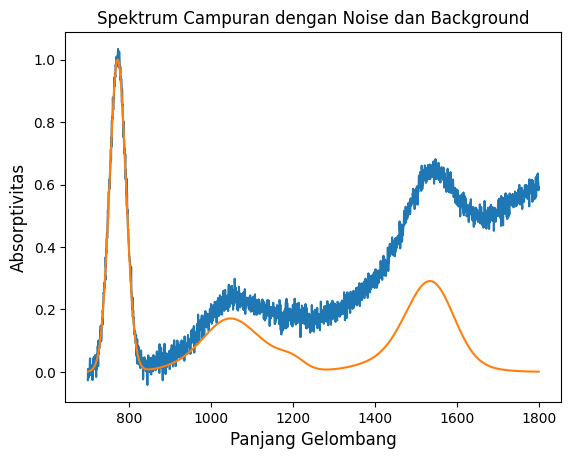

In [16]:
# Let's add some noise for a bit of realism:
clean_mixture = mixture.copy()
# Random noise:
mixture += np.random.normal(0, 0.02, size = mixture.shape)
# Baseline:

# Baseline as a polynomial background:
poly = 0.001 * np.ones(len(x_range)) + 0.000001 * x_range + 0.0000005 * (x_range - 700)**2
mixture += poly

plt.plot(x_range, mixture.T[:,115], label = 'Mixture with noise and baseline')
plt.plot(x_range, clean_mixture.T[:,115], label = 'Mixture')
plt.title('Spektrum Campuran dengan Noise dan Background', fontsize = 12)
plt.xlabel('Panjang Gelombang', fontsize = 12)
plt.ylabel('Absorptivitas', fontsize = 12)
plt.show()

In [17]:
# Estimation of the baseline:
# Parameters for this case:
l = 100000000 # smoothness
p = 0.005 # asymmetry
estimated_baselined = []
for i in range(mixture.shape[0]):
    estimated_baselined.append(baseline_als(mixture[i], l, p))
estimated_baselined = np.array(estimated_baselined).T

# Baseline subtraction:
baselined_spectrum = mixture.T - estimated_baselined

# Reasoning baseline + noise

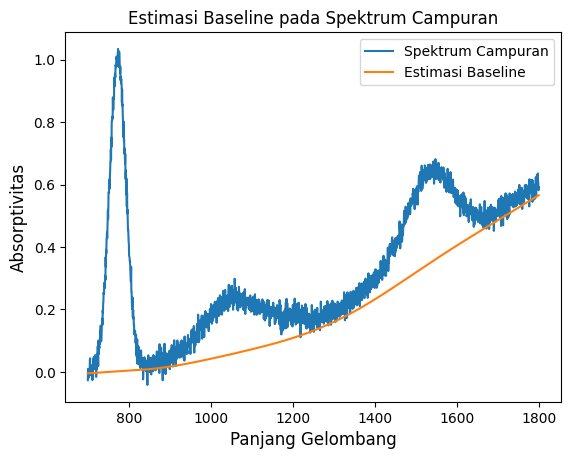

In [18]:
# How does it look like?
plt.plot(x_range, mixture[115].T, label = 'Spektrum Campuran')
plt.plot(x_range, estimated_baselined[:,0], label = 'Estimasi Baseline')
plt.title('Estimasi Baseline pada Spektrum Campuran', fontsize = 12)
plt.xlabel('Panjang Gelombang', fontsize = 12)
plt.ylabel('Absorptivitas', fontsize = 12)
plt.legend()
plt.show()

In [21]:
# Parameters:
w = 100 # window (number of points)
p = 2 # polynomial order

smoothed_spectrum = []
for i in range(baselined_spectrum.shape[1]):
    smoothed_spectrum.append(savgol_filter(baselined_spectrum[:,i], w, polyorder = p, deriv=0))
smoothed_spectrum = np.array(smoothed_spectrum)

# Some more information on the implementation of this method can be found here:
# https://nirpyresearch.com/savitzky-golay-smoothing-method/

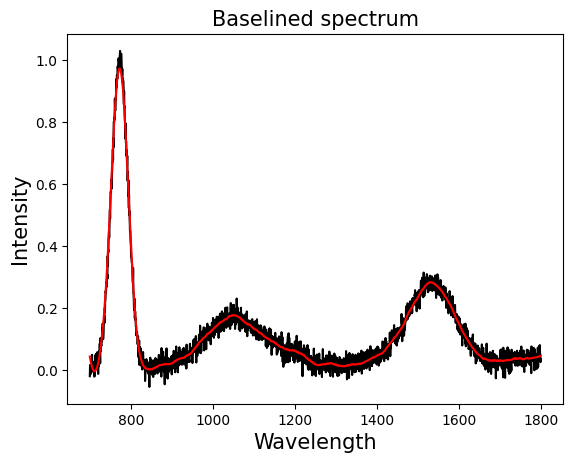

In [22]:
# We plot the mix spectrum after baseline subtraction
plt.plot(x_range, baselined_spectrum[:,115], color = 'black', label = 'Baselined spectrum with noise' )
plt.plot(x_range, smoothed_spectrum[115], color = 'red', label = 'Baselined spectrum with noise' )
plt.title('Baselined spectrum', fontsize = 15)
plt.xlabel('Wavelength', fontsize = 15)
plt.ylabel('Intensity',  fontsize = 15)
plt.show()

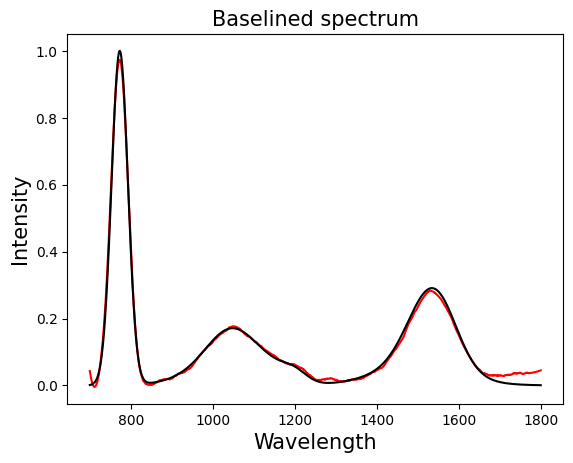

In [23]:
plt.plot(x_range, smoothed_spectrum[115], color = 'red', label = 'Baselined spectrum with noise' )
plt.plot(x_range, clean_mixture.T[:,115], color = 'black', label = 'Mixture')
plt.title('Baselined spectrum', fontsize = 15)
plt.xlabel('Wavelength', fontsize = 15)
plt.ylabel('Intensity',  fontsize = 15)
plt.show()

In [24]:
np.array([c_a, c_b, c_c]).T.shape, smoothed_spectrum.shape

((231, 3), (231, 2000))

In [40]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

X = smoothed_spectrum
concentrations = np.array([c_a, c_b, c_c]).T
# Splitting the data into train, validation and test sets:

X_train, X_test, y_train, y_test = train_test_split(X, concentrations, test_size=0.125, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=1-150/175, random_state=43)

In [41]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape, X_val.shape, y_val.shape

((173, 2000), (29, 2000), (173, 3), (29, 3), (29, 2000), (29, 3))

In [42]:
reg = LinearRegression().fit(X_train, y_train)
y_pred_train = reg.predict(X_train)
y_pred_val = reg.predict(X_val)
y_pred_test = reg.predict(X_test)

y_pred_train = np.clip(y_pred_train, 0, None)
y_pred_val = np.clip(y_pred_val, 0, None)
y_pred_test = np.clip(y_pred_test, 0, None)

In [43]:
reg.coef_.shape

(3, 2000)

In [44]:
# Evaluation metrics:
# RMSE:
rmse_train = np.sqrt(np.mean((y_pred_train - y_train)**2))
rmse_val = np.sqrt(np.mean((y_pred_val - y_val)**2))
rmse_test = np.sqrt(np.mean((y_pred_test - y_test)**2))

# MAE:
mae_train = np.mean(np.abs(y_pred_train - y_train))
mae_val = np.mean(np.abs(y_pred_val - y_val))
mae_test = np.mean(np.abs(y_pred_test - y_test))

df = pd.DataFrame({'RMSE': [rmse_train, rmse_val, rmse_test], 'MAE': [mae_train, mae_val, mae_test]}, index = ['Train', 'Validation', 'Test'])
df.round(3)

,RMSE,MAE
Train,0.000,0.000
Validation,0.011,0.008
Test,0.011,0.008


In [45]:
# Print some results:
y_test = np.round(y_test, 3)
y_pred_test = np.round(y_pred_test, 3)

df = pd.DataFrame({'Real concentration A': y_test[:,0], 'Predicted concentration A': y_pred_test[:,0], 'Real concentration B': y_test[:,1], 'Predicted concentration B': y_pred_test[:,1], 'Real concentration C': y_test[:,2], 'Predicted concentration C': y_pred_test[:,2]})
# Multi level column names:
df.columns = pd.MultiIndex.from_product([['Konsentrasi A', 'Konsentrasi B', 'Konsentrasi C'], ['Real', 'Prediksi']])
df.index += 1
df[:10]

Konsentrasi A          Konsentrasi B          Konsentrasi C         
            Real Prediksi          Real Prediksi          Real Prediksi
1           0.80    0.788          0.10    0.105          0.10    0.108
2           0.15    0.135          0.30    0.321          0.55    0.544
3           0.00    0.006          0.45    0.434          0.55    0.560
4           0.50    0.504          0.25    0.246          0.25    0.249
5           0.00    0.003          0.75    0.752          0.25    0.245
6           0.65    0.651          0.25    0.253          0.10    0.096
7           0.05    0.051          0.20    0.210          0.75    0.738
8           0.65    0.649          0.05    0.048          0.30    0.303
9           0.45    0.450          0.05    0.046          0.50    0.504
10          0.35    0.346          0.00    0.000          0.65    0.668

c:\Users\ariaw\AppData\Local\miniconda3\envs\proyek-lemak\Lib\site-packages\ternary\plotting.py:148: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(xs, ys, vmin=vmin, vmax=vmax, **kwargs)


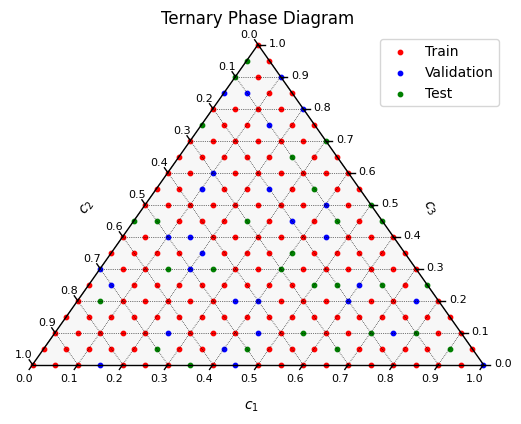

In [46]:
figure, tax = ternary.figure(scale=1.0)
tax.boundary(linewidth=1.0)
tax.gridlines(multiple=0.1, color="black")

tax.scatter(y_train, marker='o', color='red', s=10, label = 'Train')
tax.scatter(y_val, marker='o', color='blue', s=10, label = 'Validation')
tax.scatter(y_test, marker='o', color='green', s=10, label = 'Test')


tax.set_title("Ternary Phase Diagram")
tax.ticks(axis='lbr', linewidth=1, multiple=0.1, tick_formats="%.1f", offset=0.015, fontsize=8)
tax.get_axes().axis('off')
tax.bottom_axis_label(r"$c_1$", offset=0.05)
tax.left_axis_label(r"$c_2$", offset=0.14)
tax.right_axis_label(r"$c_3$", offset=0.14)
tax.clear_matplotlib_ticks()
tax.legend()
tax.show()

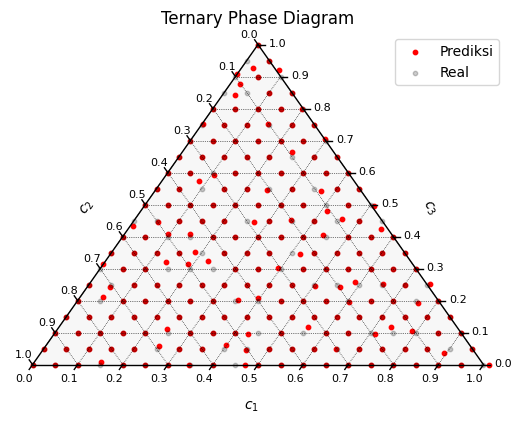

In [47]:
figure, tax = ternary.figure(scale=1.0)
tax.boundary(linewidth=1.0)
tax.gridlines(multiple=0.1, color="black")


y_pred = np.concatenate((y_pred_train, y_pred_val, y_pred_test), axis = 0)
y = np.concatenate((y_train, y_val, y_test), axis = 0)
tax.scatter(y_pred, marker='o', color='red', s=10, label = 'Prediksi')
tax.scatter(y, marker='o', color='black', s=10, label = 'Real', alpha = 0.2)

tax.set_title("Ternary Phase Diagram")
tax.ticks(axis='lbr', linewidth=1, multiple=0.1, tick_formats="%.1f", offset=0.015, fontsize=8)
tax.get_axes().axis('off')
tax.bottom_axis_label(r"$c_1$", offset=0.05)
tax.left_axis_label(r"$c_2$", offset=0.14)
tax.right_axis_label(r"$c_3$", offset=0.14)
tax.clear_matplotlib_ticks()
tax.legend()
tax.show()
